In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import glob
import cv2
import tensorflow as tf
import keras
import os
import cv2
import pickle
import random

In [2]:
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten
from keras.layers.normalization import batch_normalization
from tensorflow.keras.layers import Dense,Activation,Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from sklearn.metrics import accuracy_score , confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from matplotlib.image import imread
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import seaborn as sns


In [3]:
train = r'D:/tomato/train'
test = r'D:/tomato/val'
size=256

In [4]:
train_images = []
train_labels = []
for directory_path in glob.glob('D:/tomato/train/*'):
    label = directory_path.split("\\")[-1]
    print(label)
    for img_path in glob.glob(os.path.join(directory_path,"*.jpg")):
        #print(img_path)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img,(size,size))
        train_images.append(img)
        train_labels.append(label)

Tomato___Bacterial_spot
Tomato___healthy
Tomato___Late_blight
Tomato___Septoria_leaf_spot
Tomato___Tomato_Yellow_Leaf_Curl_Virus


In [5]:
test_images = []
test_labels = []
for directory_path in glob.glob('D:/tomato/val/*'):
    label = directory_path.split("\\")[-1]
    #print(label)
    for img_path in glob.glob(os.path.join(directory_path,"*.jpg")):
        #print(img_path)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img,(size,size))
        test_images.append(img)
        test_labels.append(label)

In [6]:
train_images = np.array(train_images)
train_labels = np.array(train_labels)
test_images = np.array(test_images)
test_labels = np.array(test_labels)

In [7]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(test_labels)
test_labels_encoded = le.transform(test_labels)
le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)

In [8]:
x_train , y_train, x_test, y_test = train_images, train_labels_encoded, test_images, test_labels_encoded

In [9]:
##########################
from tensorflow.keras.utils import to_categorical
from skimage.transform import resize


x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
y_train = to_categorical(y_train, 5)
y_test = to_categorical(y_test, 5)

###########################

In [10]:
from keras.applications import NASNetMobile 

In [11]:
teacher = NASNetMobile(weights='imagenet', include_top=False,input_shape=(size,size,3))

In [12]:
for layer in teacher.layers:
    layer.trainable = False
teacher.summary()

Model: "NASNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv1 (Conv2D)            (None, 127, 127, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 stem_bn1 (BatchNormalization)  (None, 127, 127, 32  128         ['stem_conv1[0][0]']             
                                )                                                            

In [13]:
x = Flatten()(teacher.output)
prediction = Dense(5,activation='softmax')(x)
teacher = Model(inputs=teacher.input, outputs = prediction)
teacher.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv1 (Conv2D)            (None, 127, 127, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 stem_bn1 (BatchNormalization)  (None, 127, 127, 32  128         ['stem_conv1[0][0]']             
                                )                                                             

In [14]:
# student
student=Sequential()

student.add(Conv2D(32,(3,3),activation='relu',padding='same',input_shape=(size,size,3)))
student.add(MaxPooling2D(2,2))

student.add(Conv2D(16,(2,2),activation='relu',padding='same'))
student.add(MaxPooling2D(2,2))
student.add(Conv2D(16,(2,2),activation='relu',padding='same'))
student.add(MaxPooling2D(2,2))
student.add(Flatten())
student.add(Dense(128,activation='relu'))
student.add(Dense(5,activation='softmax'))

In [15]:
student.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 16)      2064      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 16)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 16)        1040      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 16)       0

In [16]:
# Clone student for later comparison
student_scratch = keras.models.clone_model(student)

In [17]:
teacher.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [30]:
student_scratch.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [31]:
# Train and evaluate student trained from scratch.
student_scratch.fit(x_train, y_train, epochs=3)
student_scratch.evaluate(x_test, y_test)

Epoch 1/3


79/79 [==============================] - 40s 480ms/step - loss: 0.2329 - accuracy: 0.9180
Epoch 2/3
79/79 [==============================] - 50s 639ms/step - loss: 0.1600 - accuracy: 0.9440
Epoch 3/3
16/16 [==============================] - 3s 170ms/step - loss: 0.3429 - accuracy: 0.9020


[0.3428809642791748, 0.9020000100135803]

In [65]:
student_scratch_pred = student_scratch.predict(x_test)

16/16 [==============================] - 2s 115ms/step


In [66]:
predicted_classes = np.argmax(student_scratch_pred, axis=1)

true_classes = test_labels_encoded

In [69]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate Accuracy
accuracy = accuracy_score(true_classes, predicted_classes)

# Calculate precision
precision = precision_score(true_classes, predicted_classes, average='weighted')

# Calculate recall
recall = recall_score(true_classes, predicted_classes, average='weighted')

# Calculate F1 score
f1 = f1_score(true_classes, predicted_classes, average='weighted')

print("Accuracy: {:.2f}".format(accuracy))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1 Score: {:.2f}".format(f1))

Accuracy: 0.90
Precision: 0.92
Recall: 0.90
F1 Score: 0.90


In [32]:
# Train teacher model
teacher.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test))

Epoch 1/5
79/79 [==============================] - 111s 1s/step - loss: 0.0135 - accuracy: 0.9956 - val_loss: 0.7038 - val_accuracy: 0.9000
Epoch 2/5
79/79 [==============================] - 110s 1s/step - loss: 0.0044 - accuracy: 0.9984 - val_loss: 0.6273 - val_accuracy: 0.9100
Epoch 3/5
79/79 [==============================] - 110s 1s/step - loss: 0.0065 - accuracy: 0.9976 - val_loss: 0.5319 - val_accuracy: 0.9160
Epoch 4/5
79/79 [==============================] - 110s 1s/step - loss: 2.8346e-04 - accuracy: 1.0000 - val_loss: 0.5419 - val_accuracy: 0.9160
Epoch 5/5
79/79 [==============================] - 111s 1s/step - loss: 1.2277e-04 - accuracy: 1.0000 - val_loss: 0.5532 - val_accuracy: 0.9120


In [33]:
teacher.evaluate(x_test, y_test)

16/16 [==============================] - 19s 1s/step - loss: 0.5532 - accuracy: 0.9120


[0.5531638264656067, 0.9120000004768372]

In [42]:
soft_train_labels = teacher.predict(x_train)
soft_test_labels = teacher.predict(x_test)

16/16 [==============================] - 12s 719ms/step


In [70]:
teacher_pred = soft_test_labels

predicted_classes = np.argmax(teacher_pred, axis=1)

true_classes = test_labels_encoded

In [71]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate Accuracy
accuracy = accuracy_score(true_classes, predicted_classes)

# Calculate precision
precision = precision_score(true_classes, predicted_classes, average='weighted')

# Calculate recall
recall = recall_score(true_classes, predicted_classes, average='weighted')

# Calculate F1 score
f1 = f1_score(true_classes, predicted_classes, average='weighted')

print("Accuracy: {:.2f}".format(accuracy))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1 Score: {:.2f}".format(f1))

Accuracy: 0.91
Precision: 0.92
Recall: 0.91
F1 Score: 0.91


In [43]:
# Knowledge distillation loss function
def knowledge_distillation_loss(y_true, y_pred, temperature):
    y_true_softmax = tf.nn.softmax(y_true / temperature)
    y_pred_softmax = tf.nn.softmax(y_pred / temperature)
    return tf.keras.losses.kullback_leibler_divergence(y_true_softmax, y_pred_softmax) * temperature ** 2


In [77]:
temperature = 0.1

# Train student model with knowledge distillation loss
student.compile(optimizer='adam', loss=lambda y_true, y_pred: knowledge_distillation_loss(y_true, y_pred, temperature),
                      metrics=['accuracy'])
student.fit(x_train, soft_train_labels, epochs=5, validation_data=(x_test, soft_test_labels))

Epoch 1/5
79/79 [==============================] - 44s 526ms/step - loss: 0.0013 - accuracy: 0.9732 - val_loss: 0.0110 - val_accuracy: 0.8260
Epoch 2/5
79/79 [==============================] - 39s 499ms/step - loss: 6.1454e-04 - accuracy: 0.9852 - val_loss: 0.0101 - val_accuracy: 0.8400
Epoch 3/5
79/79 [==============================] - 39s 493ms/step - loss: 0.0013 - accuracy: 0.9684 - val_loss: 0.0091 - val_accuracy: 0.8400
Epoch 4/5
79/79 [==============================] - 39s 496ms/step - loss: 4.1199e-04 - accuracy: 0.9868 - val_loss: 0.0120 - val_accuracy: 0.8180
Epoch 5/5
79/79 [==============================] - 39s 496ms/step - loss: 1.9712e-04 - accuracy: 0.9956 - val_loss: 0.0088 - val_accuracy: 0.8540


In [78]:
student.evaluate(x_test, y_test)

16/16 [==============================] - 2s 104ms/step - loss: 0.0036 - accuracy: 0.9160


[0.0036164873745292425, 0.9160000085830688]

In [79]:
distilled_pred = student.predict(x_test)

16/16 [==============================] - 2s 102ms/step


In [80]:
teacher_pred = soft_test_labels

predicted_classes = np.argmax(distilled_pred, axis=1)

true_classes = test_labels_encoded

In [81]:
# Calculate Accuracy
accuracy = accuracy_score(true_classes, predicted_classes)

# Calculate precision
precision = precision_score(true_classes, predicted_classes, average='weighted')

# Calculate recall
recall = recall_score(true_classes, predicted_classes, average='weighted')

# Calculate F1 score
f1 = f1_score(true_classes, predicted_classes, average='weighted')

print("Accuracy: {:.2f}".format(accuracy))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1 Score: {:.2f}".format(f1))

Accuracy: 0.92
Precision: 0.92
Recall: 0.92
F1 Score: 0.92


(1, 256, 256, 3)


1/1 [==============================] - 0s 67ms/step


Text(0.5, 1.0, 'Predicted as : Septoria Leaf Spot')

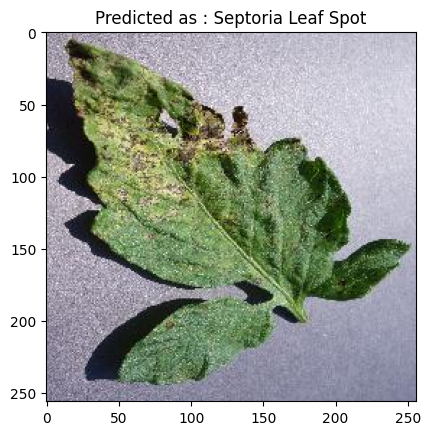

In [82]:
path = "D:/ML/Data_sets/Tomatod/tomato/test/sept.JPG"
img = load_img(path,target_size=(size,size))

i = img_to_array(img)/255
input_arr = np.array([i])
print(input_arr.shape)

plt.axis = False
plt.show()
pred = np.argmax(teacher.predict(input_arr))

results = {0:"Bacterial Spot",1:"Late Blight",2:"Septoria Leaf Spot",3:"Yellow Leaf Curl",4:"Healthy"}
prediction = results[pred]
plt.imshow(input_arr[0])
plt.title(f"Predicted as : {prediction}")

(1, 256, 256, 3)
1/1 [==============================] - 0s 37ms/step


Text(0.5, 1.0, 'Predicted as : Septoria Leaf Spot')

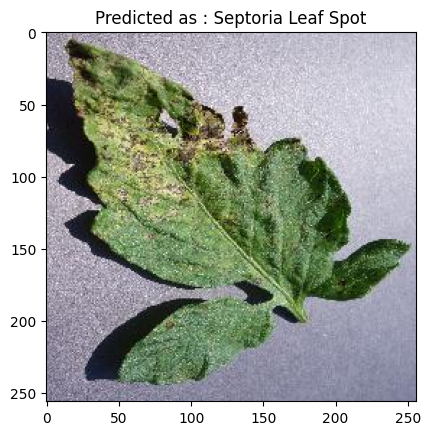

In [83]:
path = "D:/ML/Data_sets/Tomatod/tomato/test/sept.JPG"
img = load_img(path,target_size=(size,size))

i = img_to_array(img)/255
input_arr = np.array([i])
print(input_arr.shape)

plt.axis = False
plt.show()
pred = np.argmax(student_scratch.predict(input_arr))

results = {0:"Bacterial Spot",1:"Late Blight",2:"Septoria Leaf Spot",3:"Yellow Leaf Curl",4:"Healthy"}
prediction = results[pred]
plt.imshow(input_arr[0])
plt.title(f"Predicted as : {prediction}")

(1, 256, 256, 3)
1/1 [==============================] - 0s 49ms/step


Text(0.5, 1.0, 'Predicted as : Healthy')

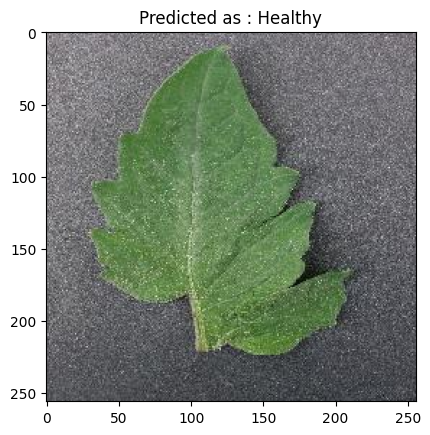

In [97]:
path = "D:/ML/Data_sets/Tomatod/tomato/test/healthy.JPG"
img = load_img(path,target_size=(size,size))

i = img_to_array(img)/255
input_arr = np.array([i])

plt.axis = False
plt.show()
pred = np.argmax(student.predict(input_arr))

results = {0:"Bacterial Spot",1:"Late Blight",2:"Septoria Leaf Spot",3:"Yellow Leaf Curl",4:"Healthy"}
prediction = results[pred]
plt.imshow(input_arr[0])
plt.title(f"Predicted as : {prediction}")

In [85]:
import pickle

pickle.dump(student,open('Distilled_Model.pkl','wb'))


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\saving\serialization_lib.py:275: UserWarning: The object being serialized includes a `lambda`. This is unsafe. In order to reload the object, you will have to pass `safe_mode=False` to the loading function. Please avoid using `lambda` in the future, and use named Python functions instead. This is the `lambda` being serialized: student.compile(optimizer='adam', loss=lambda y_true, y_pred: knowledge_distillation_loss(y_true, y_pred, temperature),
                      metrics=['accuracy'])

  return {key: serialize_keras_object(value) for key, value in obj.items()}


In [86]:
pickle.dump(student_scratch,open('Student_scratch.pkl','wb'))

In [87]:
distiller = pickle.load(open('D:/Kabil/Project_Src/Mini Project(3rd Sem)/Distilled_Model.pkl','rb'))

(1, 256, 256, 3)
1/1 [==============================] - 0s 96ms/step


Text(0.5, 1.0, 'Predicted as : Septoria Leaf Spot')

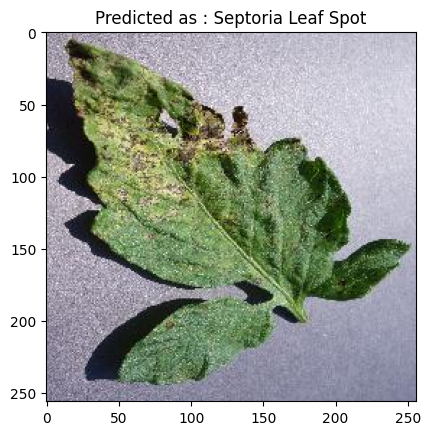

In [88]:
path = "D:/ML/Data_sets/Tomatod/tomato/test/sept.JPG"
img = load_img(path,target_size=(size,size))

i = img_to_array(img)/255
input_arr = np.array([i])
print(input_arr.shape)

plt.axis = False
plt.show()
pred = np.argmax(distiller.predict(input_arr))

results = {0:"Bacterial Spot",1:"Late Blight",2:"Septoria Leaf Spot",3:"Yellow Leaf Curl",4:"Healthy"}
prediction = results[pred]
plt.imshow(input_arr[0])
plt.title(f"Predicted as : {prediction}")

In [89]:
student.save('Dist.h5')